<a href="https://colab.research.google.com/github/Dara4hem/Semantic-Segmentation-with-BEiT-and-U-Net-Models/blob/main/BEiTv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from transformers import AutoImageProcessor, BeitForSemanticSegmentation
from PIL import Image
import torch
import torchvision.transforms as T
import albumentations as A

# Load the pre-trained BEiT model and processor
model_name = "microsoft/beit-base-finetuned-ade-640-640"
image_processor = AutoImageProcessor.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BeitForSemanticSegmentation.from_pretrained(model_name).to(device)

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset
!unzip semantic-drone-dataset.zip -d /content/semantic-drone-dataset


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 32.5 MB/s eta 0:00:00


In [4]:
IMAGE_PATH = '/content/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '/content/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

In [5]:
n_classes = 23

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [6]:
X_trainval, X_test = train_test_split(df['id'].values,test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size  : ',len(X_train))
print('Val Size  : ',len(X_val))
print('Test Size  : ',len(X_test))

Train Size  :  306
Val Size  :  54
Test Size  :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


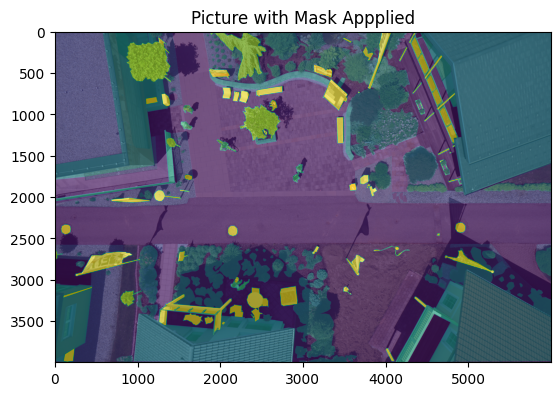

In [7]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [8]:
class DroneDataset(Dataset):
  def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
    self.img_path = img_path
    self.mask_path= mask_path
    self.X=X
    self.transform= transform
    self.patches = patch
    self.mean = mean
    self.std = std


  def __len__(self):
    return len(self.X)

  def __getitem__(self,idx):
    img= cv2.imread(self.img_path + self.X[idx] + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.mask_path + self.X[idx] + '.png' , cv2.IMREAD_GRAYSCALE)

    if self.transform is not None:
      aug= self.transform(image=img , mask= mask)
      img= Image.fromarray(aug['image'])
      mask = aug['mask']

    if self.transform  is None :
      img = Image.fromarray(img)

    t=T.Compose([T.ToTensor(), T.Normalize(self.mean,self.std)])
    img = t(img)
    mask = torch.from_numpy(mask).long()

    if self.patches :
      img,mask = self.tiles(img,mask)
    return img,mask

  def tiles(self,img,mask):
    img_patches = img.unfold(1,512, 512).unfold(2,768,768)
    img_patches = img_patches.contiguous().view(3,-1,512,768)
    img_patches = img_patches.permute(1,0,2,3)

    mask_patches =mask.unfold(0,512,512).unfold(1,768,768)
    mask_patches =mask_patches.contiguous().view(-1,512,768)

    return img_patches , mask_patches


In [ ]:
!pip install transformers
!pip install torch
!pip install albumentations

In [10]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
t_train = A.Compose([
    A.Resize(640, 640, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.GridDistortion(p=0.2),
    A.RandomBrightnessContrast((0,0.5),(0,0.5)),
    A.GaussNoise()
])

t_val = A.Compose([
    A.Resize(640, 640, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(),
    A.GridDistortion(p=0.2)
])

# Update the DroneDataset class with the new transformations
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)
batch_size = 2  # Try reducing the batch size further if needed
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [11]:
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import autocast, GradScaler  # For mixed precision
import torch.nn.functional as F

# Define accuracy calculation function
def calculate_accuracy(logits, targets):
    # Get the predicted classes by taking the argmax along the channel dimension
    _, preds = torch.max(logits, dim=1)
    correct = (preds == targets).sum().item()
    total = targets.numel()
    accuracy = correct / total
    return accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    scaler = GradScaler()  # For mixed precision
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        # Training phase
        model.train()
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for inputs, targets in train_progress:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            with autocast():  # Mixed precision context
                outputs = model(pixel_values=inputs, labels=targets)
                logits = outputs.logits

                # Resize logits to match the size of the target
                logits = F.interpolate(logits, size=targets.shape[-2:], mode="bilinear", align_corners=False)

                loss = criterion(logits, targets)

            # Backward pass and optimization with mixed precision
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            accuracy = calculate_accuracy(logits, targets)
            running_corrects += accuracy * inputs.size(0)
            total_samples += inputs.size(0)

            train_progress.set_postfix({"Loss": running_loss / total_samples, "Accuracy": running_corrects / total_samples})

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = running_corrects / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        # Adjust learning rate
        scheduler.step()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total_samples = 0

        with torch.no_grad():
            val_progress = tqdm(val_loader, desc="Validation")
            for inputs, targets in val_progress:
                inputs = inputs.to(device)
                targets = targets.to(device)

                with autocast():  # Mixed precision context
                    outputs = model(pixel_values=inputs, labels=targets)
                    logits = outputs.logits

                    # Resize logits to match the size of the target
                    logits = F.interpolate(logits, size=targets.shape[-2:], mode="bilinear", align_corners=False)

                    loss = criterion(logits, targets)

                val_loss += loss.item() * inputs.size(0)
                accuracy = calculate_accuracy(logits, targets)
                val_corrects += accuracy * inputs.size(0)
                val_total_samples += inputs.size(0)

                val_progress.set_postfix({"Loss": val_loss / val_total_samples, "Accuracy": val_corrects / val_total_samples})

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = val_corrects / len(val_loader.dataset)
        print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")

# Define the optimizer, criterion, and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# Start training
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)


Epoch 1/10:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.7331, Accuracy: 0.4513


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Validation Loss: 1.5293, Validation Accuracy: 0.6315


Epoch 2/10:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.3456, Accuracy: 0.6705


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Validation Loss: 0.8949, Validation Accuracy: 0.7664


Epoch 3/10:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.0230, Accuracy: 0.7386


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Validation Loss: 0.7467, Validation Accuracy: 0.7949


Epoch 4/10:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.8858, Accuracy: 0.7622


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Validation Loss: 0.6504, Validation Accuracy: 0.8145


Epoch 5/10:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.7593, Accuracy: 0.7890


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Validation Loss: 0.6291, Validation Accuracy: 0.8171


Epoch 6/10:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.7051, Accuracy: 0.7994


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Validation Loss: 0.5945, Validation Accuracy: 0.8260


Epoch 7/10:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.6991, Accuracy: 0.8061


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Validation Loss: 0.5975, Validation Accuracy: 0.8268


Epoch 8/10:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.6850, Accuracy: 0.8050


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Validation Loss: 0.5991, Validation Accuracy: 0.8286


Epoch 9/10:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.6449, Accuracy: 0.8172


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Validation Loss: 0.5754, Validation Accuracy: 0.8307


Epoch 10/10:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.6517, Accuracy: 0.8149


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

Validation Loss: 0.5879, Validation Accuracy: 0.8309
